# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU.

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [1]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2025-10-05 03:51:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  20.1MB/s    in 3.9s    

2025-10-05 03:51:14 (16.7 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -qo cats_and_dogs_filtered.zip

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [3]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring.

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test.

In [4]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    # transforms.RandomVerticalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
                                    # transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    # transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),  # convert PIL to Pytorch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

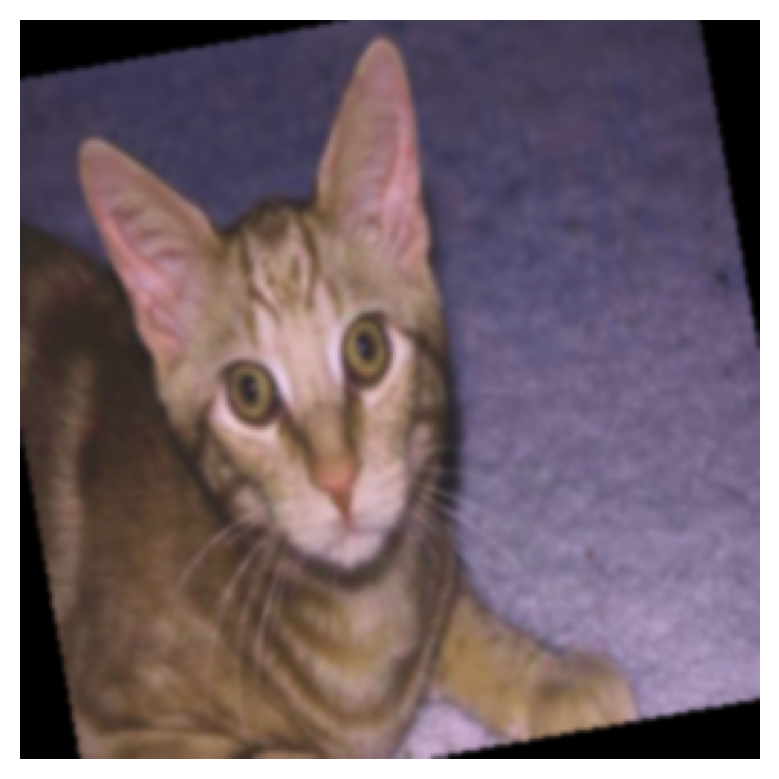

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(train_dataset[10][0])

### Creating the model

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [6]:
import torch
from torch import nn

class CNN_Solution(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Block 1 ---
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        self.conv1_res = nn.Conv2d(3, 32, kernel_size=1)

        # --- Block 2 ---
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.conv2_res = nn.Conv2d(32, 64, kernel_size=1)

        # --- Block 3 ---
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )
        self.conv3_res = nn.Conv2d(64, 128, kernel_size=1)

        # --- Block 4 ---
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
        )
        self.conv4_res = nn.Conv2d(128, 256, kernel_size=1)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout
        self.dropout = nn.Dropout(0.3)

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        # --- Block 1 ---
        out = self.conv1(x)
        res = self.conv1_res(x)
        out = self.relu(out + res)
        out = self.pool(out)

        # --- Block 2 ---
        out2 = self.conv2(out)
        res2 = self.conv2_res(out)
        out = self.relu(out2 + res2)
        out = self.pool(out)

        # --- Block 3 ---
        out3 = self.conv3(out)
        res3 = self.conv3_res(out)
        out = self.relu(out3 + res3)
        out = self.pool(out)

        # --- Block 4 ---
        out4 = self.conv4(out)
        res4 = self.conv4_res(out)
        out = self.relu(out4 + res4)
        out = self.pool(out)

        # Global pooling + classifier
        out = self.global_pool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [7]:
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

def get_loss_and_correct(model, batch, criterion, device):
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  _, preds = torch.max(outputs, 1)
  correct = torch.sum(preds == labels.data)
  return loss, correct

def step(loss, optimizer):
  optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
  optimizer.step()


N_EPOCHS = 50
BATCH_SIZE = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN_Solution()

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

scheduler = CosineAnnealingLR(optimizer, T_max=len(train_dataloader)*N_EPOCHS)

model.train()

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = 0.0
  total_train_correct = 0.0
  total_validation_loss = 0.0
  total_validation_correct = 0.0

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct.item()
    scheduler.step()

  with torch.no_grad():
    for batch in validation_dataloader:
      loss, correct = get_loss_and_correct(model, batch, criterion, device)
      total_validation_loss += loss.item()
      total_validation_correct += correct.item()

  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)

  mean_validation_loss = total_validation_loss / len(validation_dataset)
  validation_accuracy = total_validation_correct / len(validation_dataset)

  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)

  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)

  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

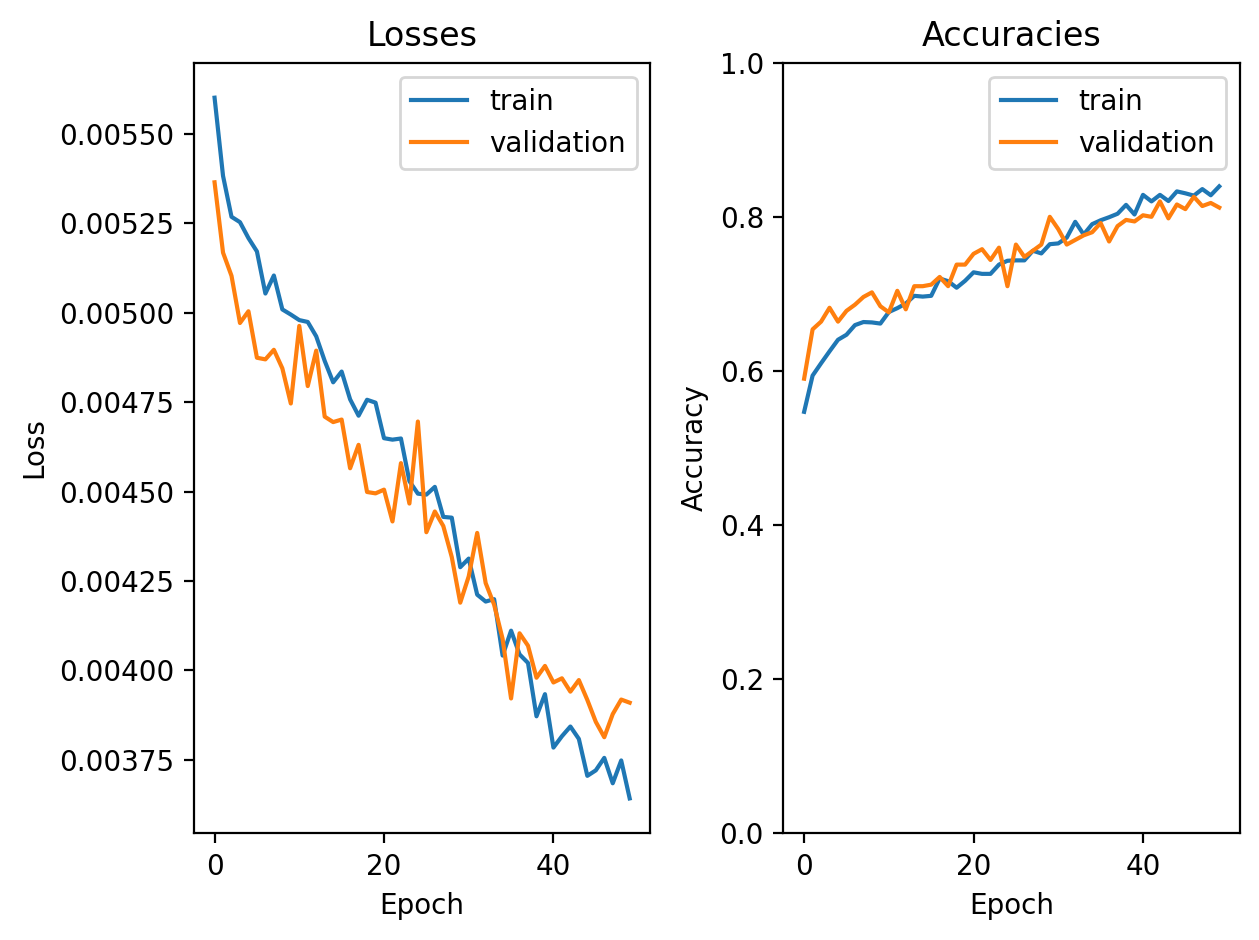

In [8]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations.

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer: Looking at these loss and accuracy plots, the model does *not* appear to be overfitting the training set:

**Evidence Against Overfitting:**

1. *Training and validation losses track closely together*: Both curves decrease in tandem throughout training. The validation loss stays very close to the training loss and even occasionally goes lower. There's no significant divergence between them.

2. *Training and validation accuracies are similar*: Both accuracy curves increase together and remain closely aligned. The validation accuracy tracks the training accuracy throughout, and by the end of training, they're at approximately the same level (~81%).

3. *No divergence pattern*: In overfitting, we would have typically observed the following signs:
   - Training loss continuing to decrease while validation loss starts increasing
   - Training accuracy continuing to improve while validation accuracy plateaus or decreases
   
   Neither of these patterns is present here.

4. **Similar final performance**: At the final epoch, both train and validation metrics have converged to similar values, suggesting the model generalizes well to unseen data.

This indicates that the model is *generalizing well*. The close alignment between training and validation metrics throughout the entire training process indicates that the model is learning patterns that apply to both the training and validation sets and there's no memorization of the training data occurring.

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [9]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4)

model.eval()
test_correct = 0
test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        test_loss += loss.item()
        test_correct += correct.item()

test_accuracy = test_correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7500


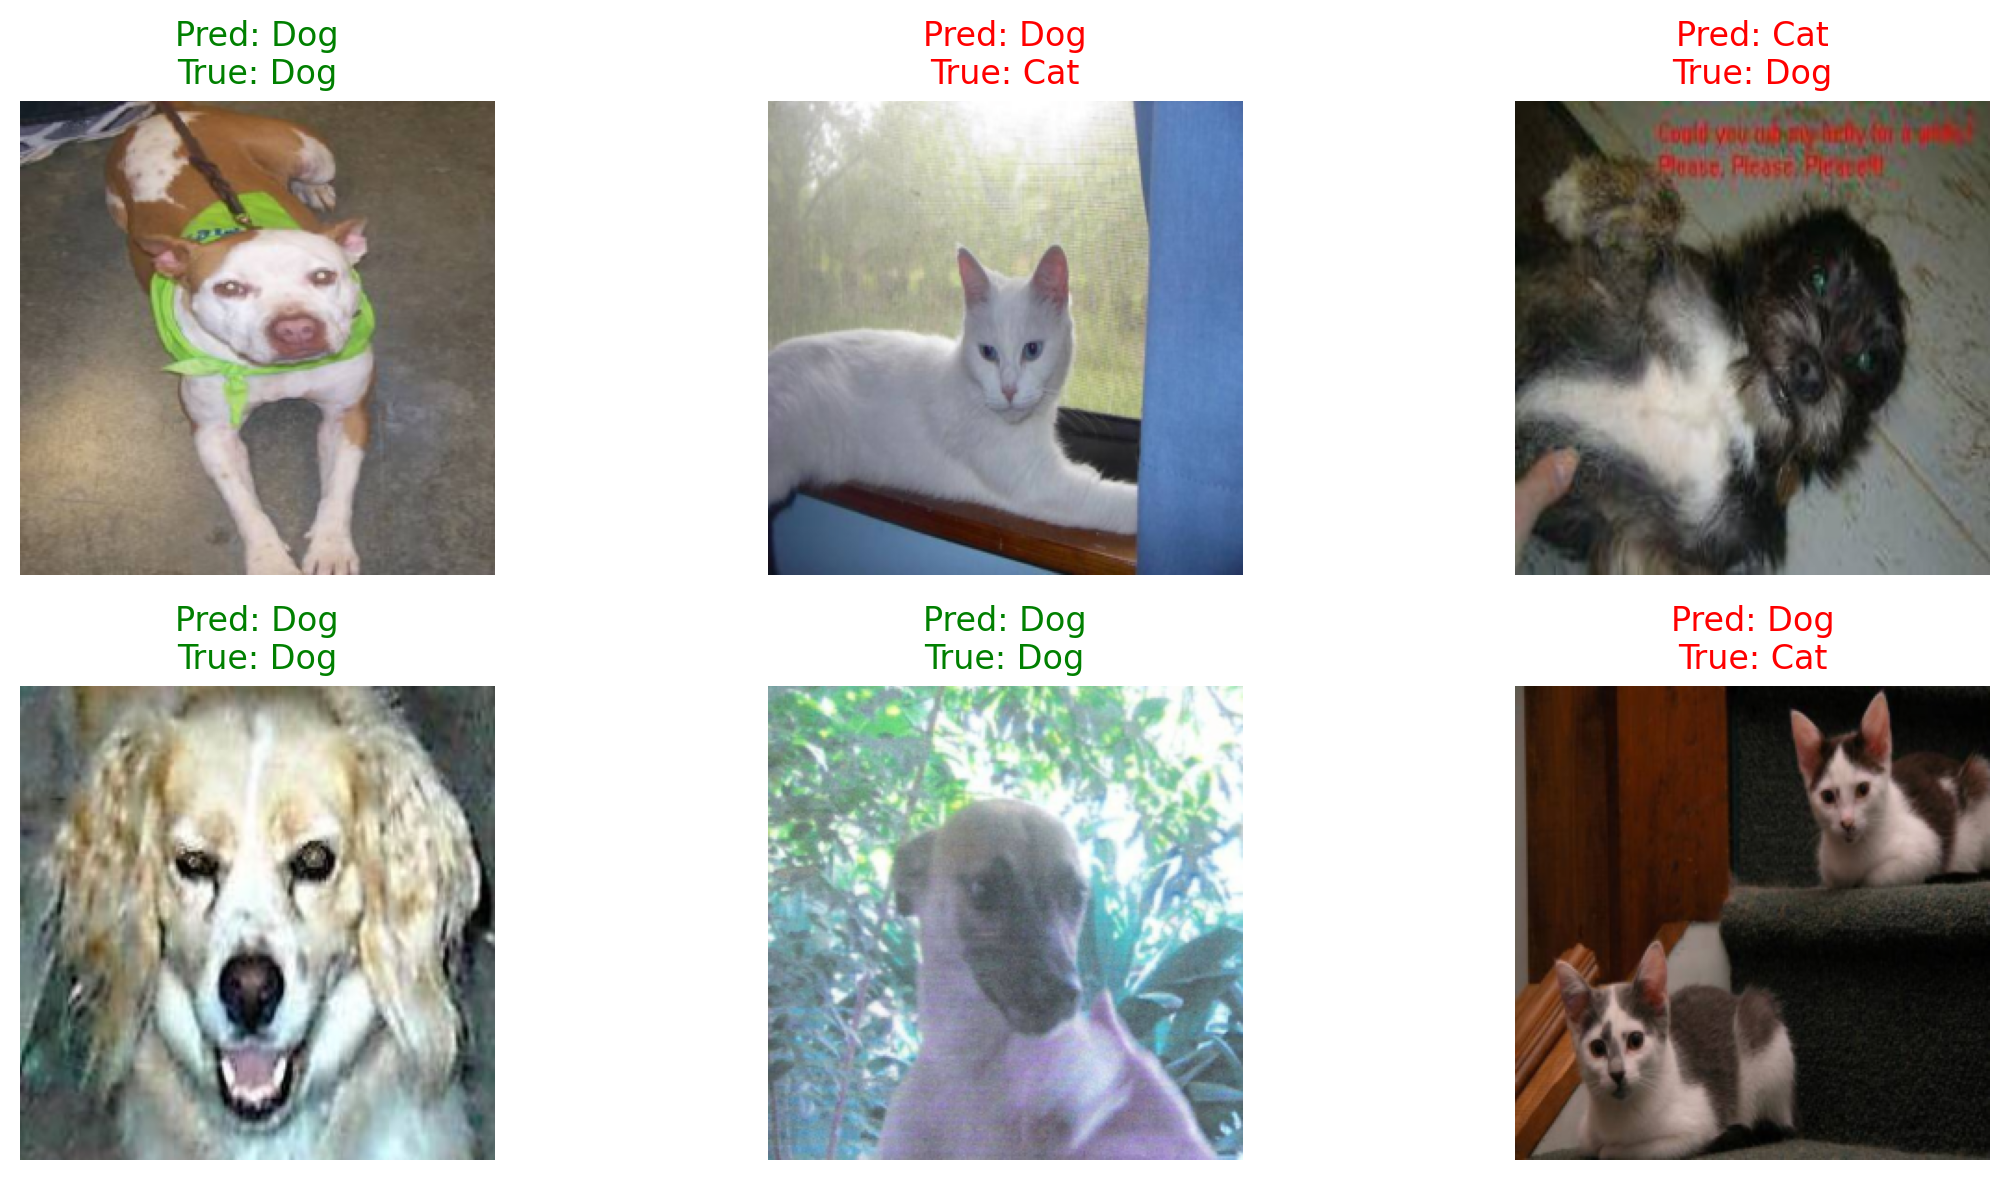

In [10]:
import random

def visualize_predictions(model, dataset, n=6):
    model.eval()
    correct_examples = []
    incorrect_examples = []

    # Collect predictions for the whole dataset
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()
        if pred == label:
            correct_examples.append((img, label, pred))
        else:
            incorrect_examples.append((img, label, pred))

    # Sample equal number of correct and incorrect
    n_correct = min(len(correct_examples), n // 2)
    n_incorrect = min(len(incorrect_examples), n - n_correct)

    examples = random.sample(correct_examples, n_correct) + random.sample(incorrect_examples, n_incorrect)
    random.shuffle(examples)

    fig, axs = plt.subplots(2, n // 2, figsize=(12, 6))
    axs = axs.flatten()

    for ax, (img, label, pred) in zip(axs, examples):
        ax.imshow(unnormalize(img).permute(1,2,0).cpu())
        ax.axis("off")
        if pred == label:
            ax.set_title(f"Pred: {'Dog' if pred else 'Cat'}\nTrue: {'Dog' if label else 'Cat'}", color="green")
        else:
            ax.set_title(f"Pred: {'Dog' if pred else 'Cat'}\nTrue: {'Dog' if label else 'Cat'}", color="red")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, n=6)

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

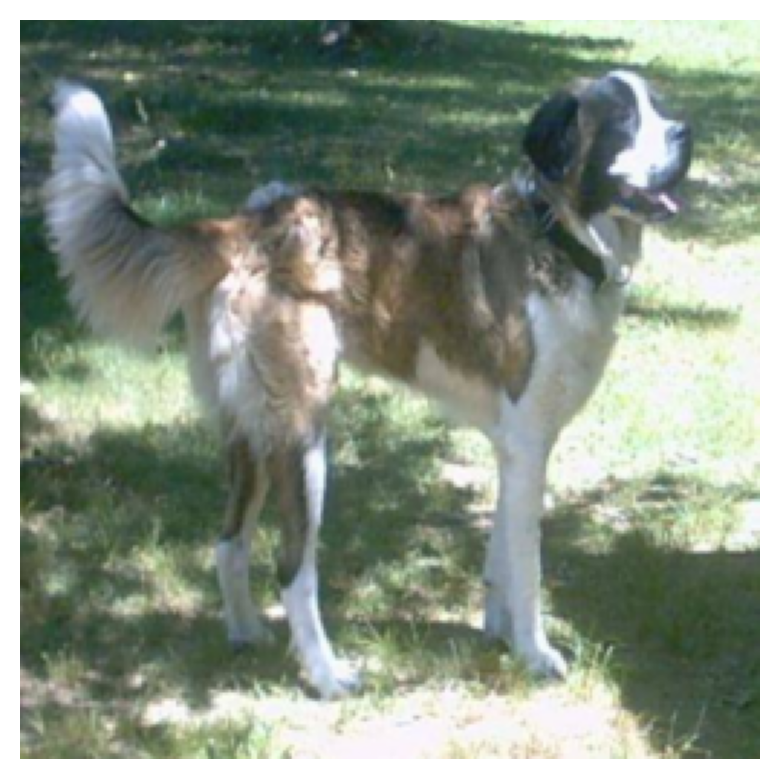

In [11]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation.
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



In [12]:
import math

def plot_intermediate_output(result, title):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert N * M >= n_filters

  fig, axs = plt.subplots(N, M)
  fig.suptitle(title)

  for i in range(N):
    for j in range(M):
      if i*N + j < n_filters:
        axs[i][j].imshow(result[0, i*N + j].cpu().detach())
        axs[i][j].axis('off')

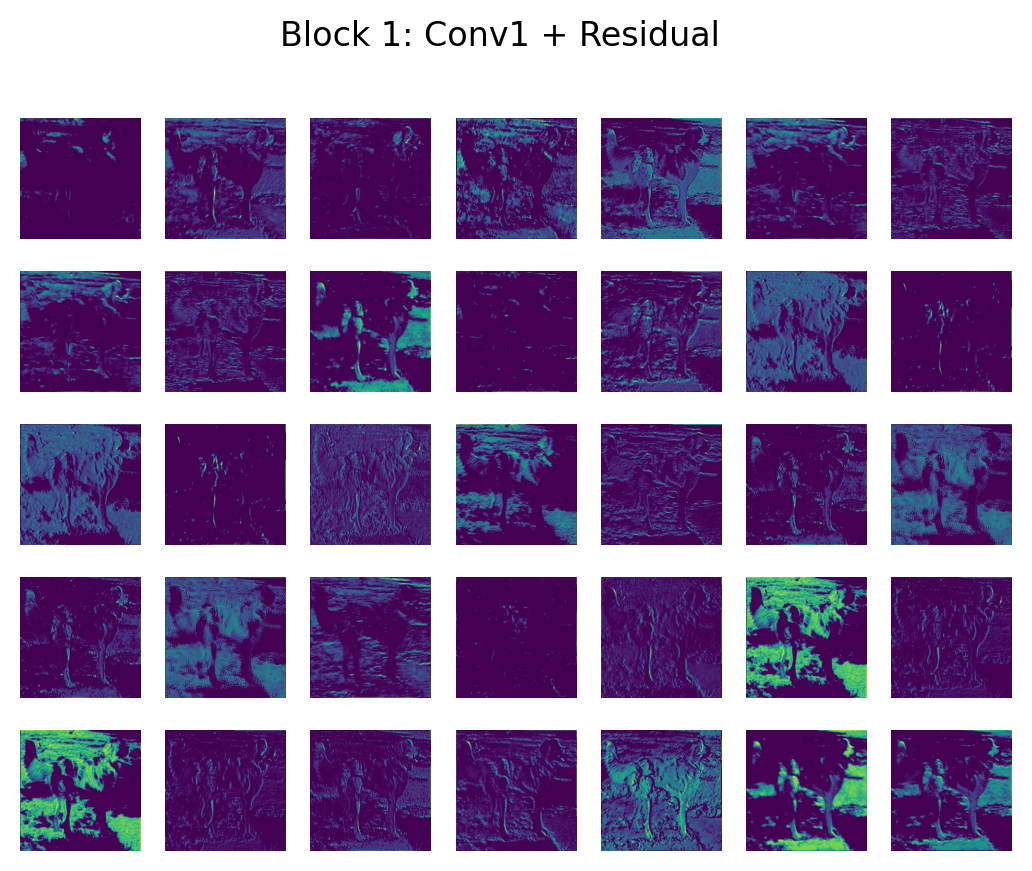

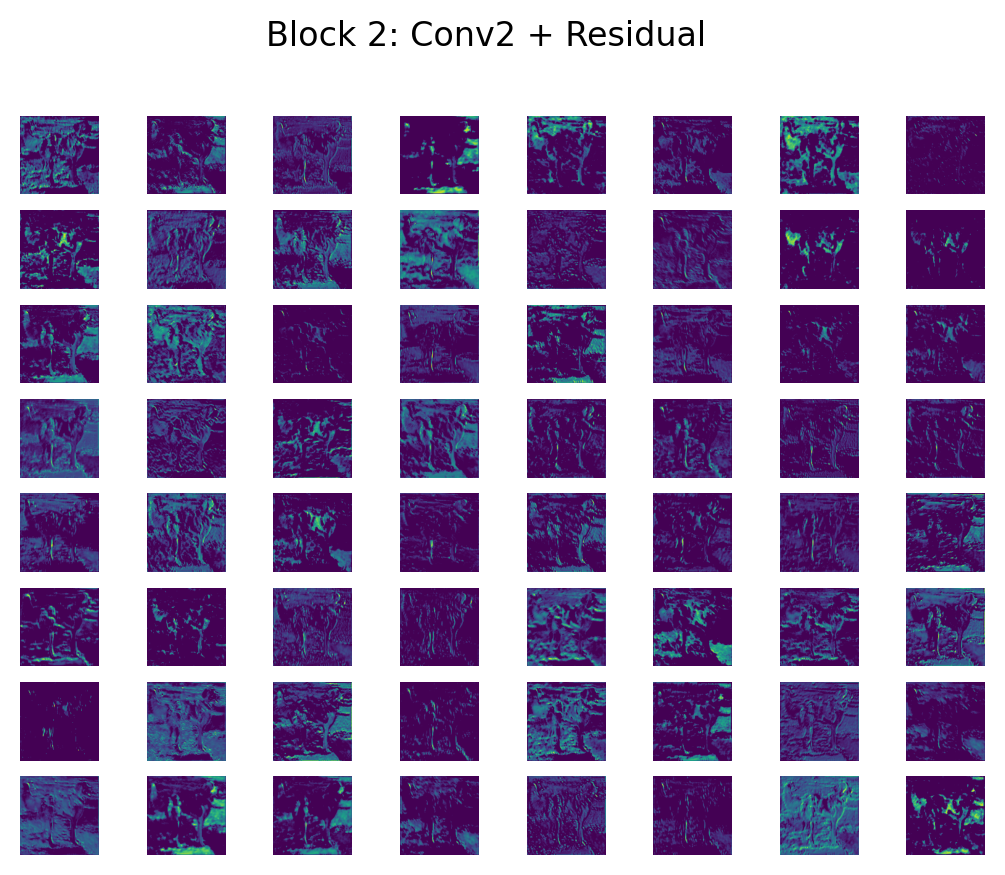

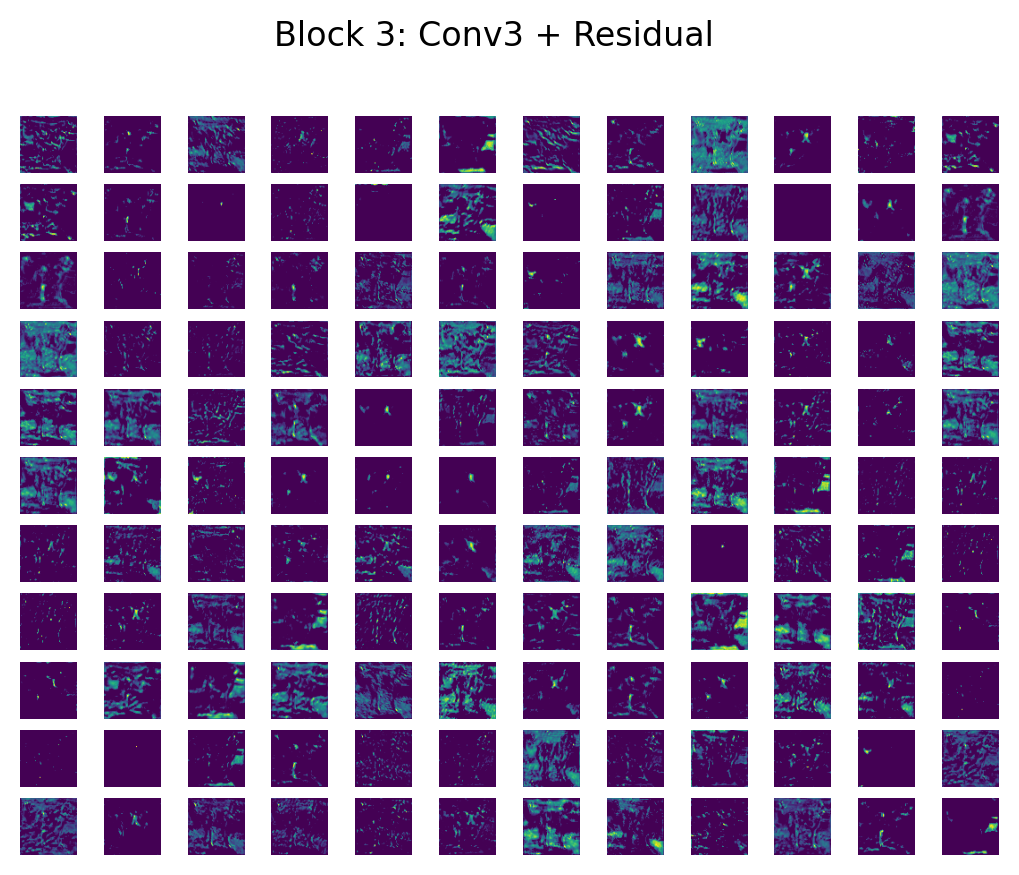

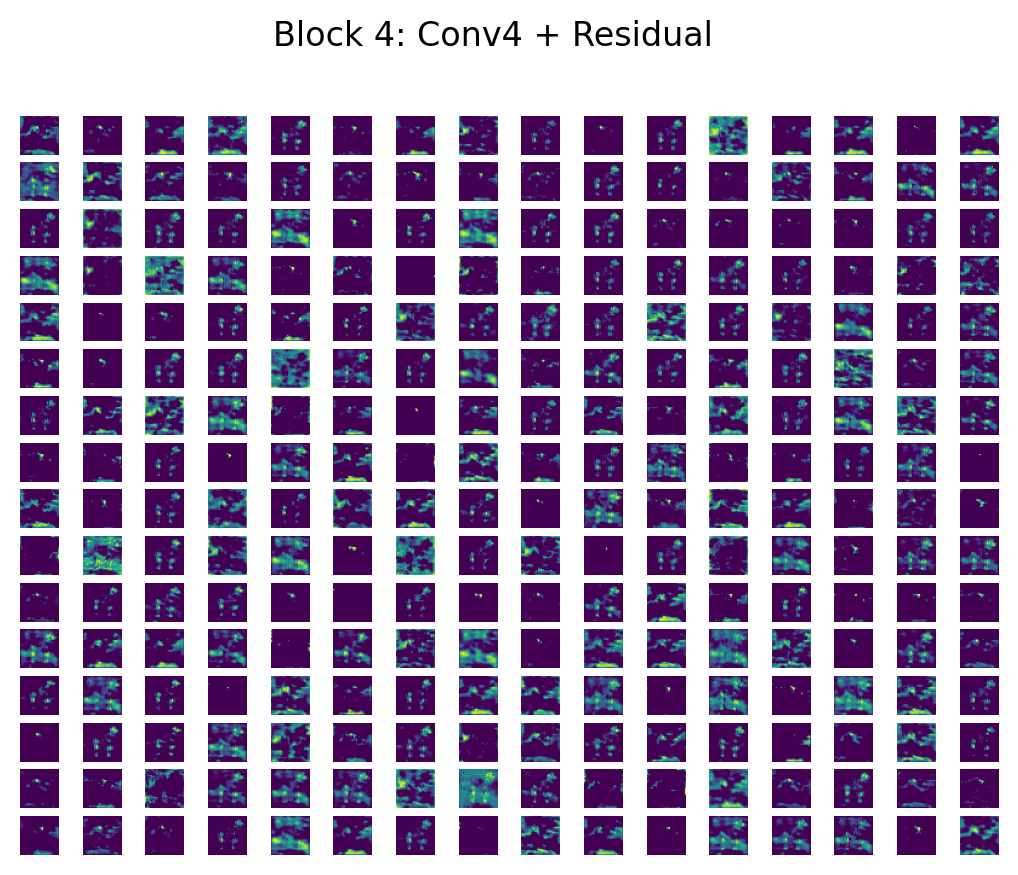

In [13]:
image = image.unsqueeze(0).to(device)

# --- Block 1 ---
out1 = model.conv1(image)
res1 = model.conv1_res(image)
out1 = model.relu(out1 + res1)
plot_intermediate_output(out1, "Block 1: Conv1 + Residual")
out1_pooled = model.pool(out1)

# --- Block 2 ---
out2 = model.conv2(out1_pooled)
res2 = model.conv2_res(out1_pooled)
out2 = model.relu(out2 + res2)
plot_intermediate_output(out2, "Block 2: Conv2 + Residual")
out2_pooled = model.pool(out2)

# --- Block 3 ---
out3 = model.conv3(out2_pooled)
res3 = model.conv3_res(out2_pooled)
out3 = model.relu(out3 + res3)
plot_intermediate_output(out3, "Block 3: Conv3 + Residual")
out3_pooled = model.pool(out3)

# --- Block 4 ---
out4 = model.conv4(out3_pooled)
res4 = model.conv4_res(out3_pooled)
out4 = model.relu(out4 + res4)
plot_intermediate_output(out4, "Block 4: Conv4 + Residual")
out4_pooled = model.pool(out4)

# --- Fully Connected ---
glob = model.global_pool(out4_pooled)
flat = torch.flatten(glob, 1)
hidden = model.fc[:-1](flat)

What can you say about those filters? What features are they focusing on?

Anwer: When we visualize the intermediate feature maps of our CNN for this dog image, we can observe the following patterns:

- **Block 1 (Conv1 + Residual):** Captures low-level features such as edges, corners, and simple color gradients. Some channels highlight the edges along the dog's body, tail, and face, while others respond to patches of brown and white fur.

- **Block 2 (Conv2 + Residual):** Combines simple edges into more complex textures and shapes. Rough outlines of the dog's tail, legs, and back fur appear in several channels.

- **Block 3 (Conv3 + Residual):** Captures higher-level combinations of features, such as parts of the dog's head, neck, legs, and tail. Some channels selectively highlight the fur texture and colors, and key shapes like the dog's back and outline.

- **Block 4 (Conv4 + Residual):** Focuses on high-level semantic features useful for distinguishing the dog from a cat. Channels are highly selective, activating strongly for the dog's distinctive fur patterns and body shape.

**Overall:** The feature maps progress from detecting basic edges and color patches to highlighting object-specific textures and shapes of the dog.